### Import Libraries

In [65]:
import pandas as pd
import numpy as np
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import re

from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report

from tensorflow.keras import Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Input, Dropout, GlobalAveragePooling1D

### Data Overview

In [43]:
df_data = pd.read_csv('text_clean.csv')
df_data.head()

,text_clean,sentiment
0,warung milik usaha pabrik puluh kenal putih ba...,positive
1,mohon ulama lurus k 212 mmbri hujjah partai di...,neutral
2,lokasi strategis jalan sumatra bandung nyaman ...,positive
3,betapa bahagia unboxing paket barang bagus beli,positive
4,aduh mahasiswa sombong kasih kartu kuning ajar...,negative


In [44]:
df_data[df_data['text_clean'].isnull()]

,text_clean,sentiment


### Tokenizing data

In [45]:
# Assign Tokenizer() ke tokenizer
tokenizer = Tokenizer()

# Fit text nya ke tokenizer
tokenizer.fit_on_texts(df_data['text_clean'])

# Dibuat sequence
sequence = tokenizer.texts_to_sequences(df_data['text_clean'])

#### Assign X dan y

In [46]:
# Assign hasil pad sequence dari data teks untuk training ke dalam variabel X
X = pad_sequences(sequence, maxlen=64) # Pad sequence nya, dibuat maxlen berdasarkan panjang maksimal kata dalam satu baris string di data_df

# Assign data sentimen sebagai target yang mau diprediksi ke dalam variabel y, diubah jadi array
label2id = {'neutral': 0, 'positive': 1, 'negative': 2}
df_data['sentiment'] = df_data['sentiment'].map(label2id) 
y = df_data['sentiment'].values

In [47]:
# Pakai OneHotEncoder
onehot = OneHotEncoder()
y_hot = onehot.fit_transform(y.reshape(-1,1)).toarray() # Balikin lagi bentuknya ke array

In [48]:
print(X.shape)
print(y_hot.shape)

(11000, 64)
(11000, 3)


### Split data

In [49]:
# Pakai train_test_split buat bagi data train sama data test
X_train, X_val, y_train, y_val = train_test_split(X, y_hot, random_state=123, train_size=0.75, shuffle=True)

In [50]:
print('X_train:', X_train.shape)
print('X_val:', X_val.shape)
print('y_train:', y_train.shape)
print('y_val:', y_val.shape)

X_train: (8250, 64)
X_val: (2750, 64)
y_train: (8250, 3)
y_val: (2750, 3)


### LSTM Modeling

In [51]:
embed_dim = 128

model = Sequential()
model.add(Embedding(15000, embed_dim, input_length= X_train.shape[1]))
model.add(Dropout(0.2))
# model.add(LSTM(64, dropout=0.2))
model.add(LSTM(32, dropout=0.2))
model.add(Dense(3, activation='softmax'))
               
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

# Early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=80, restore_best_weights=True)

# Compile model
model.compile(optimizer='sgd',
              loss=loss_fn,
              metrics=['accuracy'])
model.summary()

c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [52]:
# Simpan hasil train ke history
n_epochs = 100
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_val, y_val), callbacks=[es], batch_size=64)

Epoch 1/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.5634 - loss: 1.0325 - val_accuracy: 0.5905 - val_loss: 0.9213
Epoch 2/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.5737 - loss: 0.9261 - val_accuracy: 0.5905 - val_loss: 0.8914
Epoch 3/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.5862 - loss: 0.9008 - val_accuracy: 0.5905 - val_loss: 0.8714
Epoch 4/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.5825 - loss: 0.8866 - val_accuracy: 0.6233 - val_loss: 0.8391
Epoch 5/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6149 - loss: 0.8503 - val_accuracy: 0.6655 - val_loss: 0.8051
Epoch 6/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6436 - loss: 0.8289 - val_accuracy: 0.6862 - val_loss: 0.7919
Epoch 7/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6566 - loss: 0.8075 - val_accuracy: 0.6873 - val_loss: 0.7825
Epoch 8/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6608 - loss: 0.8004 - 

In [53]:
result = history.history
num_ep = np.arange(0, len(result['accuracy']))

### Visualisasi loss dan val_loss saat training

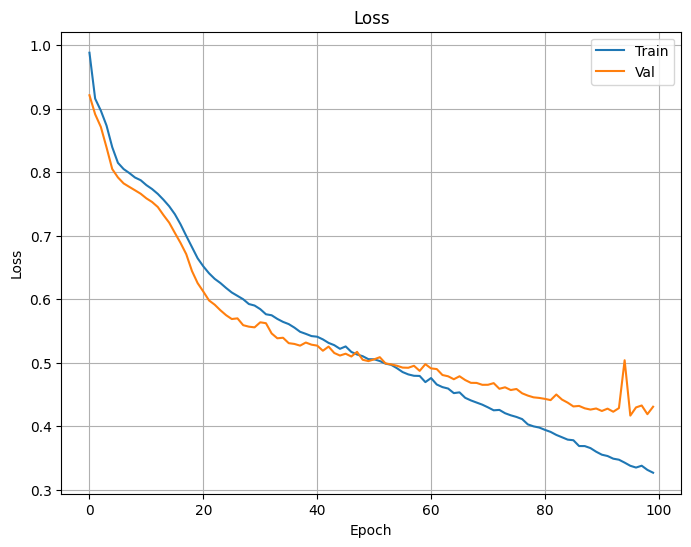

In [56]:
plt.figure(figsize=(8,6))
plt.title('Loss')
plt.plot(num_ep, result['loss'])
plt.plot(num_ep, result['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])
plt.grid()
plt.show()

### Visualisasi accuracy dan val_accuracy saat training

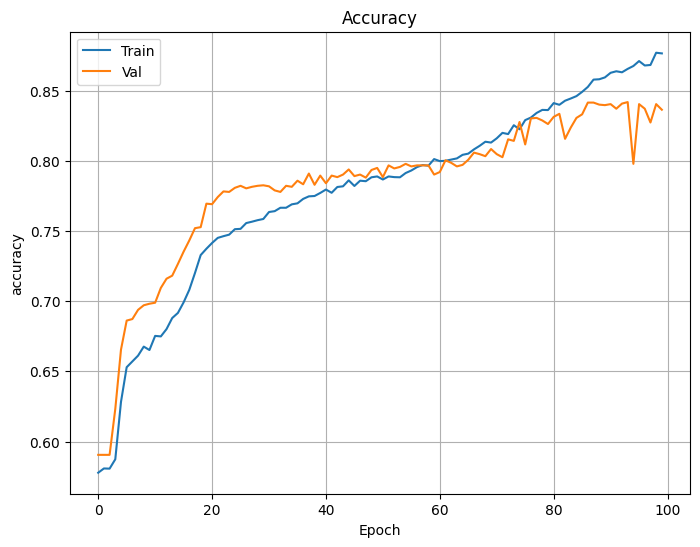

In [57]:
plt.figure(figsize=(8,6))
plt.title('Accuracy')
plt.plot(num_ep, result['accuracy'])
plt.plot(num_ep, result['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(['Train', 'Val'])
plt.grid()
plt.show()

### Visualisasi accuracy dan loss saat training

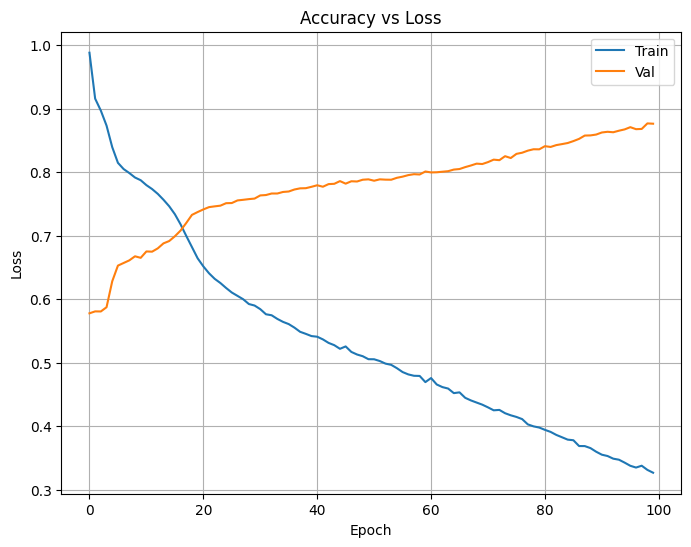

In [58]:
plt.figure(figsize=(8,6))
plt.title('Accuracy vs Loss')
plt.plot(num_ep, result['loss'])
plt.plot(num_ep, result['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])
plt.grid()
plt.show()

### Predict

In [62]:
y_pred = model.predict(X_val)

# argmax untuk mengambil best possibility dari output
y_pred_arg = y_pred.argmax(axis=1)
y_val_arg = y_val.argmax(axis=1)

print("Done")
print(classification_report(y_pred_arg, y_val_arg, zero_division=0.0))

accuracy = accuracy_score(y_pred_arg, y_val_arg)
print('Accuracy Score SGD (0.0005) :', round(accuracy, 2))

86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Done
              precision    recall  f1-score   support

           0       0.53      0.71      0.61       203
           1       0.89      0.92      0.90      1583
           2       0.84      0.74      0.79       964

    accuracy                           0.84      2750
   macro avg       0.75      0.79      0.77      2750
weighted avg       0.85      0.84      0.84      2750

Accuracy Score SGD (0.0005) : 0.84


In [63]:
# Save model
model.save('LSTM.h5')

### Tes Model dengan input teks

In [69]:
def cleansing(text):
    text = re.sub(r'\\t|\\n|\\u', ' ', text) #Menghapus karakter khusus seperti tab, baris baru, karakter Unicode, dan backslash.
    text = re.sub(r"https?:[^\s]+", ' ', text)  # Menghapus http / https
    text = re.sub(r'(\b\w+)-\1\b', r'\1', text)
    text = re.sub(r'[\\x]+[a-z0-9]{2}', '', text)  # Menghapus karakter yang dimulai dengan '\x' diikuti oleh dua karakter huruf atau angka
    # text = re.sub(r'(\d+)', r' \1 ', text)  # Memisahkan angka dari teks
    text = re.sub(r'[^a-zA-Z]+', ' ', text)  # Menghapus karakter kecuali huruf, dan spasi
    text = re.sub(r'\brt\b|\buser\b', ' ', text) # Menghapus kata-kata 'rt' dan 'user'
    text = text.lower()
    return text

label = ['negative', 'neutral', 'positive']

original_text = ' Anjing Kau prabowo!'
cleaned_text = cleansing(original_text)
text_sequence = tokenizer.texts_to_sequences([cleaned_text])
text_padded = pad_sequences(text_sequence, maxlen=64)

pred_result = model.predict(text_padded)[0]
pred_result_arg = np.argmax(pred_result)
predicted_label = label[pred_result_arg]

print('Sentiment :')
print(predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Sentiment :
positive
